## DATA 558 - Homework 4
#### Anushna Prakash
#### April 30th, 2021

##### Coordinate Descent
$$
F(\beta) = \frac{1}{2} (y - x\beta)^2 + \lambda|\beta|
$$

Implement soft-thresholding in the $n = d = 1$ case. Assume $x = y = 1$ and $\lambda = 0.5$

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
def f(beta, x, y, lambda_):
    return (1/2) * (y - x * beta)**2 + lambda_* np.abs(beta)

def soft_thresholding(x, y, lambda_):
    if (x * y) > lambda_:
        return (x*y - lambda_) / x**2
    elif (x * y) < -lambda_:
        return (x*y + lambda_) / x**2
    else:
        return 0

In [47]:
lambda_ = 0.5
x = 1
y = 1
beta = np.arange(-2, 2, 0.5)
obj = f(beta, x, y, lambda_)
st = soft_thresholding(x, y, lambda_)

Text(0, 0.5, '$F(\\beta)$')

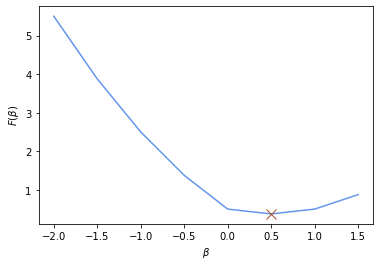

In [55]:
plt.plot(beta, obj, c = "cornflowerblue")
plt.plot(st, f(st, x, y, lambda_), marker = 'x', markersize = 10, c = 'sienna')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$F(\beta)$')